In [1]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from scipy import signal

import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

import os

In [3]:
print(os.listdir("Data/genres_original"))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [4]:
#Understanding the Audio File

y, sr = librosa.load("Data/genres_original/blues/blues.00000.wav")

print("Sound Array :", y)
print("Sample Rate (KHz)", sr)

Sound Array : [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]
Sample Rate (KHz) 22050


In [5]:
#Trimming the Silence sequences sandwiching the audio file

y, _ = librosa.effects.trim(y)
print(y)

#Observe no preceeding or succeding silence

[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]


Text(0.5, 1.0, 'Waveform in Blues 0')

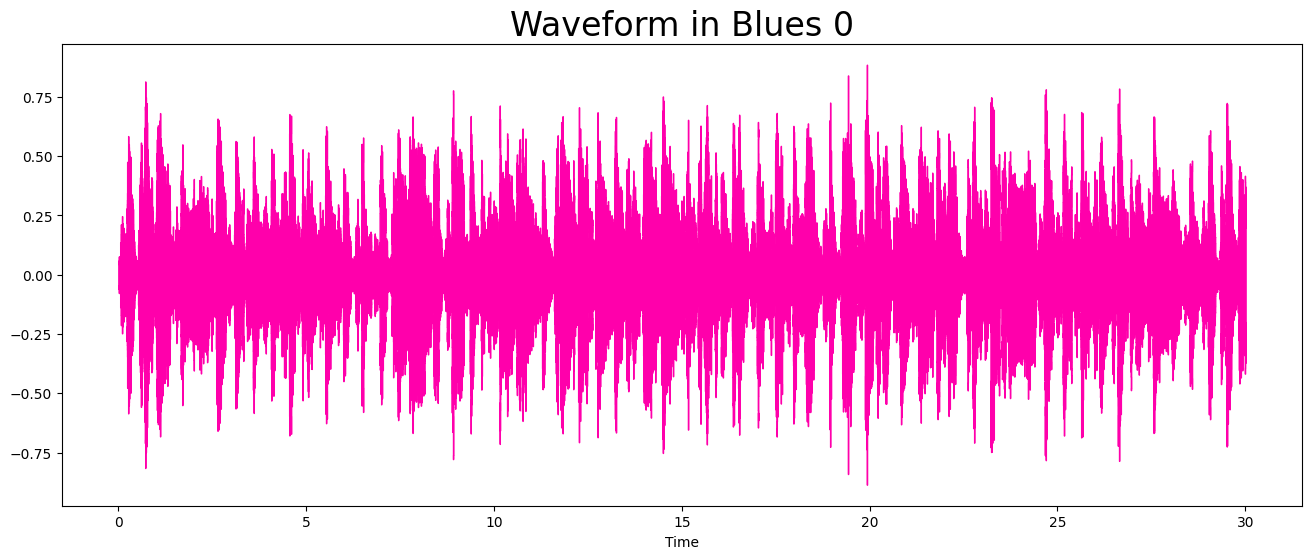

In [6]:
#2D Representation using Waveform

plt.figure(figsize = (16,6))
librosa.display.waveshow(y = y, sr = sr, color = "#FF00AB");
plt.title("Waveform in Blues 0", fontsize = 24)

In [7]:
#Decomposing the waveform based on the frequencies using FFT

n_fft = 2048
hop_length = 512

D = np.abs(librosa.stft(y, n_fft = n_fft, hop_length = hop_length))



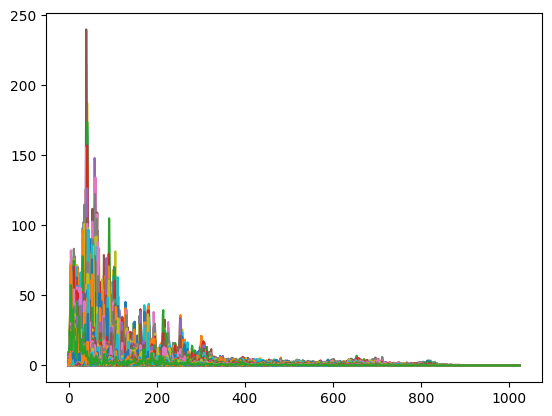

In [8]:
plt.plot(D)
plt.show()

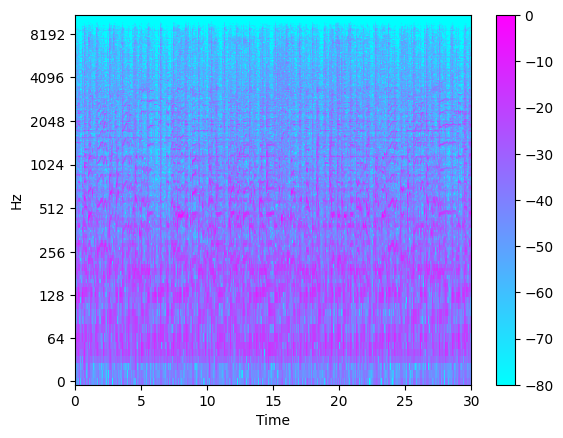

In [9]:
#Creating Log Frequency Spectogram from the FFT Signal
#This also scales to the decibel system, as that is also log based.

Deci = librosa.amplitude_to_db(D, ref = np.max)
librosa.display.specshow(Deci, sr = sr, hop_length=hop_length, x_axis='time',y_axis='log',cmap = 'cool')

plt.colorbar()

Text(0.5, 1.0, 'Mel Spectrogram')

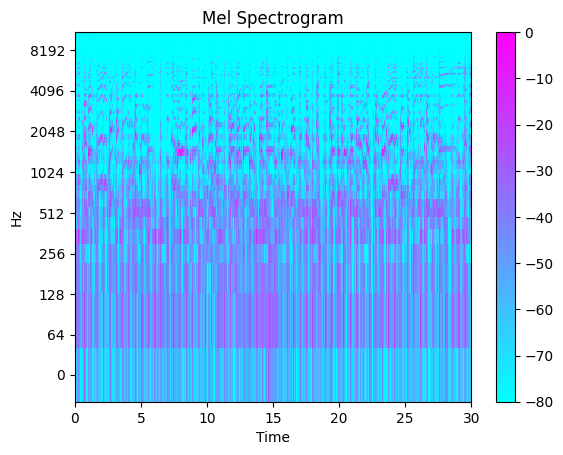

In [10]:
#Mel Spectrogram form the data

Mel_S = librosa.feature.melspectrogram(y =y, sr= sr)
Deci_S = librosa.amplitude_to_db(Mel_S, ref = np.max)
librosa.display.specshow(Deci_S, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',cmap = 'cool')
plt.colorbar()
plt.title("Mel Spectrogram", fontsize = 12)

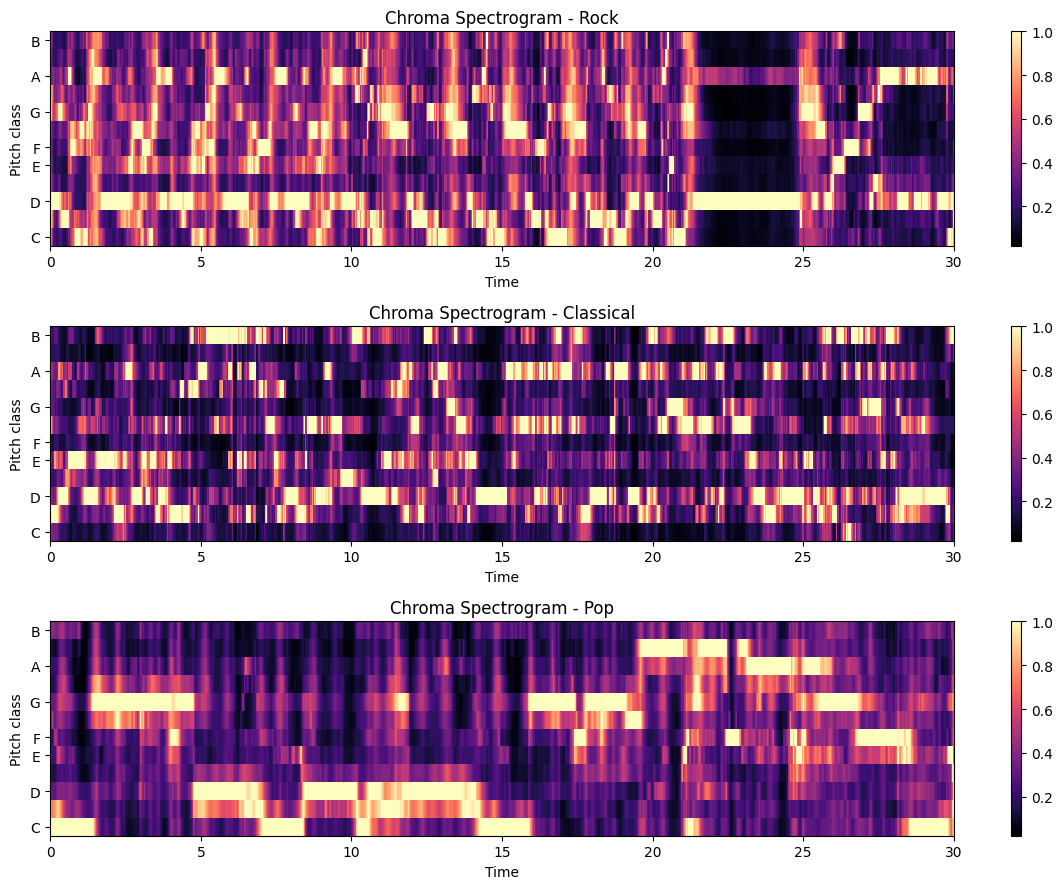

In [11]:
#Chroma Spectogram
#This represents the energy distribution across pitch classes
#Lets compare 3 genres, Rock, Pop and Classical

rock, r_sr = librosa.load("Data/genres_original/rock/rock.00000.wav")
classical, c_sr = librosa.load("Data/genres_original/classical/classical.00000.wav")
pop, p_sr = librosa.load("Data/genres_original/pop/pop.00000.wav")



# Compute chroma spectrograms for each genre
chroma_rock = librosa.feature.chroma_cqt(y=rock, sr=r_sr)
chroma_cls = librosa.feature.chroma_cqt(y=classical, sr=c_sr)
chroma_pop = librosa.feature.chroma_cqt(y=pop, sr=p_sr)


# Plot the chroma spectrograms for each genre
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
librosa.display.specshow(chroma_rock, sr=r_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Rock')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 2)
librosa.display.specshow(chroma_cls, sr=c_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Classical')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 3)
librosa.display.specshow(chroma_pop, sr=p_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Pop')
plt.colorbar()
plt.tight_layout()

plt.show()

As can be seen through the chroma spectogram, the Rock and Classical Music seem to have the melodies consisting to a lot of notes at the same time, while the pop music(for general audience) consist very few notes at the same instant.
Even if multiple notes are present at same time in Pop, they are usually harmonies i.e. 3rd or 5th of the root note.

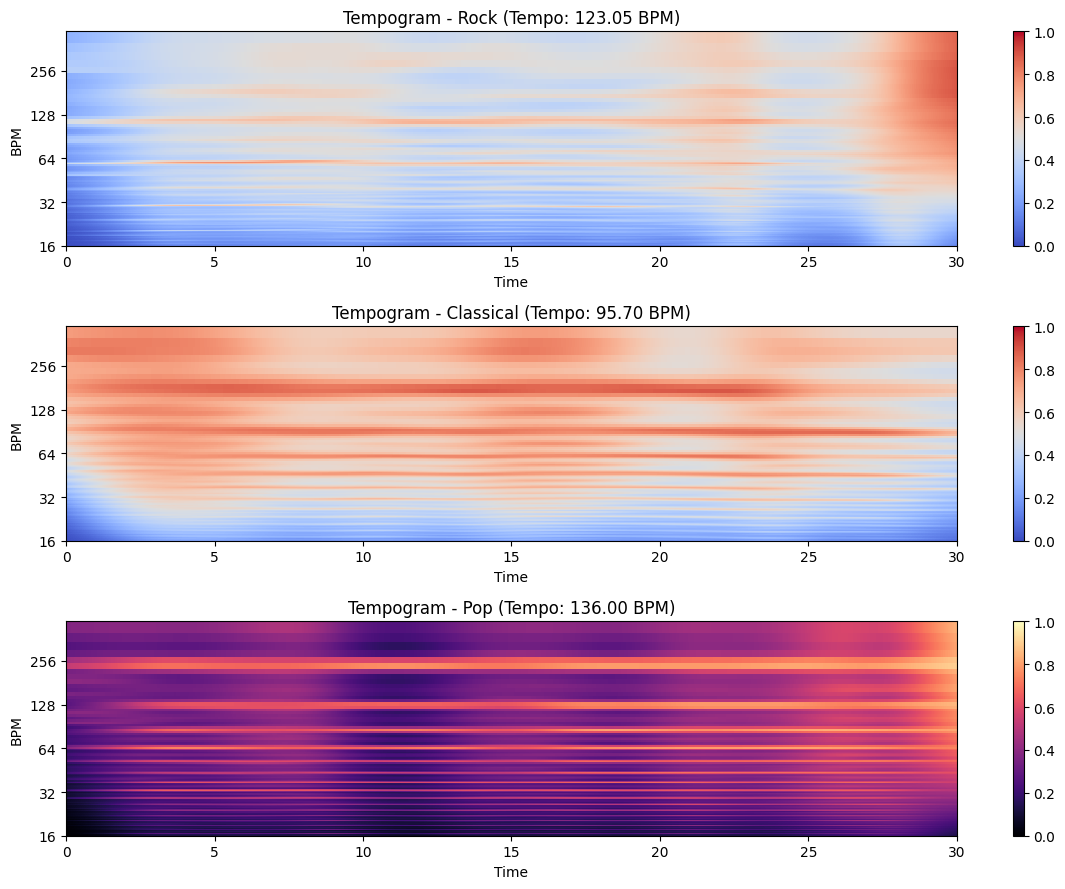

In [12]:
# Compute tempograms for each genre
tempo_rock= librosa.beat.tempo(y=rock, sr=r_sr)
tempogram_rock = librosa.feature.tempogram(y=rock, sr=r_sr, hop_length=512, win_length=384, window=np.hanning)

tempo_cls = librosa.beat.tempo(y=classical, sr=c_sr)
tempogram_cls = librosa.feature.tempogram(y=classical, sr=c_sr, hop_length=512, win_length=384, window=np.hanning)

tempo_pop = librosa.beat.tempo(y=pop, sr=p_sr)
tempogram_pop = librosa.feature.tempogram(y=pop, sr=p_sr, hop_length=512, win_length=384, window=np.hanning)

# Plot the tempograms for each genre
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
librosa.display.specshow(tempogram_rock, sr=r_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Rock (Tempo: {:.2f} BPM)'.format(tempo_rock[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 2)
librosa.display.specshow(tempogram_cls, sr=c_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Classical (Tempo: {:.2f} BPM)'.format(tempo_cls[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 3)
librosa.display.specshow(tempogram_pop, sr=p_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Pop (Tempo: {:.2f} BPM)'.format(tempo_pop[0]))
plt.colorbar()
plt.tight_layout()

plt.show()

Not much can be said able the genres with just looking at the tempograms, 
so let's overlay the tempogram with the CQT spectogram, which provides the pitch over time for the audio file.

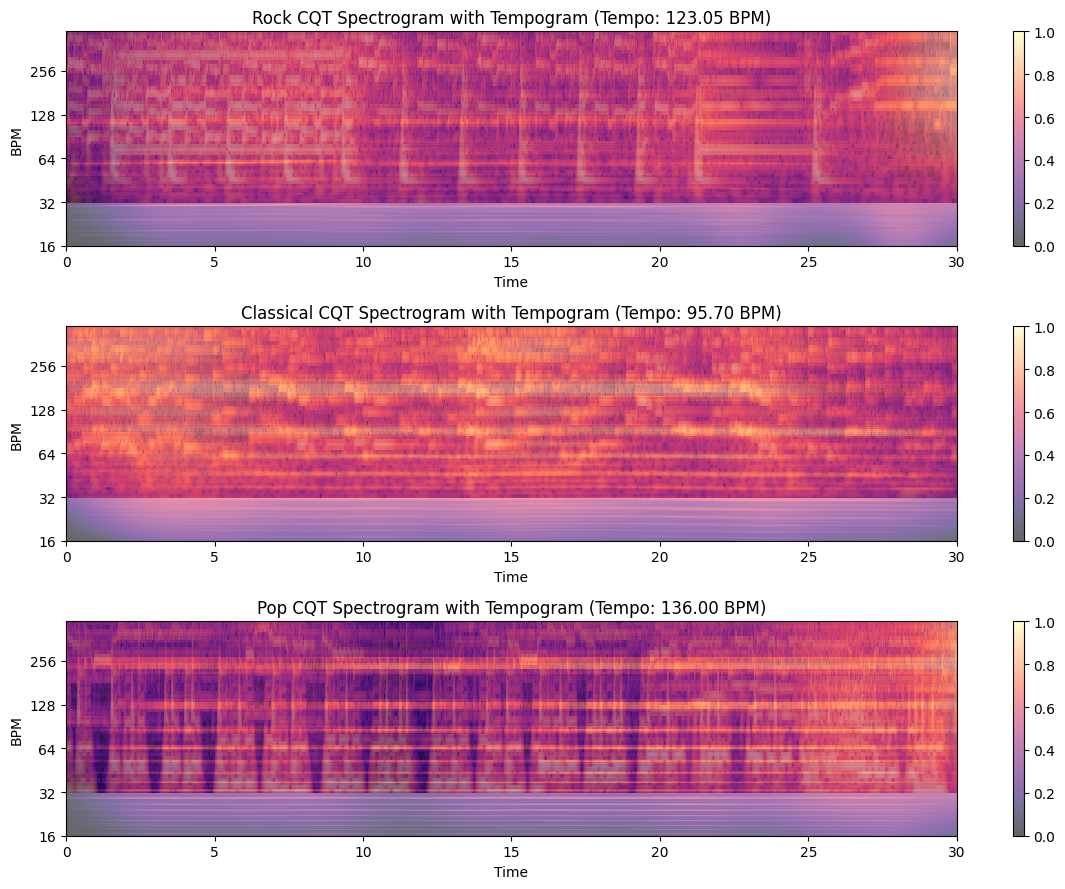

In [13]:
# Compute CQT spectrograms for each genre
cqt_rock = np.abs(librosa.cqt(rock, sr=r_sr, hop_length=512))
cqt_cls = np.abs(librosa.cqt(classical, sr=c_sr, hop_length=512))
cqt_pop = np.abs(librosa.cqt(pop, sr=p_sr, hop_length=512))

# cqt_rock = sklearn.preprocessing.scale(cqt_rock, axis=1)
# cqt_cls = sklearn.preprocessing.scale(cqt_cls, axis=1)
# cqt_pop = sklearn.preprocessing.scale(cqt_pop, axis=1)
# Plot the CQT spectrograms with tempograms overlaid for each genre
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(cqt_rock, ref=np.max), sr=r_sr, hop_length=512, x_axis='time', y_axis='cqt_note')
librosa.display.specshow(tempogram_rock, sr=r_sr, hop_length=512, x_axis='time', y_axis='tempo', cmap='magma', alpha=0.6)
plt.title('Rock CQT Spectrogram with Tempogram (Tempo: {:.2f} BPM)'.format(tempo_rock[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(cqt_cls, ref=np.max), sr=c_sr, hop_length=512, x_axis='time', y_axis='cqt_note')
librosa.display.specshow(tempogram_cls, sr=c_sr, hop_length=512, x_axis='time', y_axis='tempo', cmap='magma', alpha=0.6)
plt.title('Classical CQT Spectrogram with Tempogram (Tempo: {:.2f} BPM)'.format(tempo_cls[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(cqt_pop, ref=np.max), sr=p_sr, hop_length=512, x_axis='time', y_axis='cqt_note')
librosa.display.specshow(tempogram_pop, sr=p_sr, hop_length=512, x_axis='time', y_axis='tempo', cmap='magma', alpha=0.6)
plt.title('Pop CQT Spectrogram with Tempogram (Tempo: {:.2f} BPM)'.format(tempo_pop[0]))
plt.colorbar()
plt.tight_layout()

plt.show()


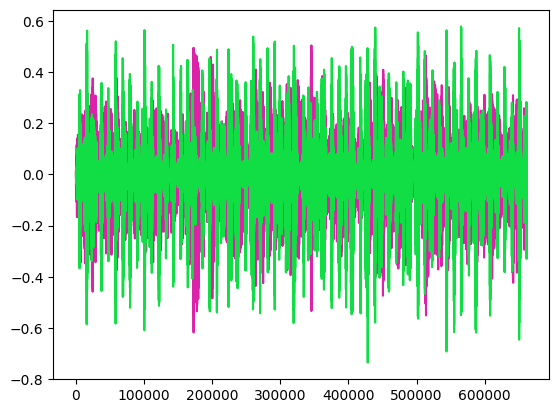

In [14]:
#Harmonics and Percussive for the Audio file

y_harm, y_perc = librosa.effects.hpss(y)
plt.plot(y_harm, color = '#DD22AA')
plt.plot(y_perc, color = '#11DD44')
plt.show()

In [15]:
from sklearn import preprocessing

In [16]:
data = pd.read_csv("Data/features_3_sec.csv")
print(data.shape)

(9990, 60)


In [17]:
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [19]:
data.drop(['filename','length'], axis = 1, inplace = True)

In [20]:
data

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [21]:
X = data.iloc[:,:-1]

In [22]:
X.shape

(9990, 57)

In [23]:
Y = data.iloc[:,-1]

In [24]:
Y

0       blues
1       blues
2       blues
3       blues
4       blues
        ...  
9985     rock
9986     rock
9987     rock
9988     rock
9989     rock
Name: label, Length: 9990, dtype: object

In [25]:
scaler = preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(X)

In [26]:
columns = X.columns

In [27]:
X_scaled = pd.DataFrame(scaled_data, columns = columns)

In [28]:
X_scaled

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.355399,0.716757,0.293133,0.107955,0.262173,0.034784,0.459205,0.094130,0.346153,0.083164,...,0.363613,0.056198,0.397172,0.066062,0.371828,0.055344,0.380831,0.026797,0.506746,0.047781
1,0.367322,0.670347,0.253040,0.044447,0.270969,0.018716,0.470831,0.052261,0.363722,0.051694,...,0.468596,0.092912,0.351681,0.074001,0.362068,0.076365,0.418452,0.082414,0.593029,0.065548
2,0.373159,0.728067,0.296753,0.141663,0.265293,0.023073,0.494051,0.059922,0.378215,0.060820,...,0.479681,0.096704,0.420979,0.050639,0.400536,0.067509,0.433742,0.043841,0.546264,0.036062
3,0.399349,0.677066,0.298024,0.075042,0.238427,0.023187,0.455246,0.066234,0.329587,0.070906,...,0.386258,0.067995,0.387474,0.050617,0.380430,0.050030,0.405824,0.041898,0.562204,0.034873
4,0.355668,0.689113,0.322308,0.052149,0.233460,0.016451,0.451651,0.047830,0.318453,0.046916,...,0.438567,0.042500,0.460314,0.083860,0.388590,0.076524,0.409019,0.020763,0.517913,0.031713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.376757,0.617031,0.111106,0.002984,0.206932,0.034101,0.380041,0.068680,0.266983,0.065229,...,0.494342,0.060299,0.302553,0.069546,0.285713,0.044089,0.371046,0.040116,0.536263,0.042502
9986,0.413243,0.637013,0.128944,0.002687,0.277274,0.058465,0.438552,0.079860,0.349793,0.090105,...,0.438282,0.045545,0.249505,0.122777,0.305915,0.081395,0.263338,0.052963,0.516365,0.020232
9987,0.374196,0.697548,0.116503,0.021500,0.176099,0.138139,0.331163,0.111494,0.202062,0.200409,...,0.391617,0.112660,0.408760,0.038190,0.442668,0.035995,0.496892,0.039921,0.505937,0.045380
9988,0.436537,0.657745,0.148266,0.009825,0.324968,0.042367,0.473422,0.017567,0.413964,0.038187,...,0.469334,0.039551,0.362864,0.029532,0.471308,0.028749,0.506738,0.019101,0.519900,0.013740


In [29]:
from sklearn.decomposition import PCA

In [30]:
for i in range(1,57):
    pca_dummy = PCA(n_components = i)

    dummy_trans = pca_dummy.fit_transform(X_scaled)

    print(pca_dummy.explained_variance_ratio_.cumsum()[i-1],i)

0.2674562115423106 1
0.44983624401319394 2
0.5307729242137398 3
0.5880377921863427 4
0.6380888840348451 5
0.6777285201195014 6
0.705815260122378 7
0.7316666701854515 8
0.7525322565693525 9
0.7708346376594621 10
0.7860581610864693 11
0.8006215607948226 12
0.8135696487552186 13
0.8251469618187568 14
0.8358832841545187 15
0.8462105489625845 16
0.8551830181736984 17
0.8639157823665629 18
0.872465009022379 19
0.8804601584134593 20
0.8882123811486448 21
0.895366617527206 22
0.902052800077434 23
0.9078878694071725 24
0.9137226397494016 25
0.9192783408209416 26
0.924310017340443 27
0.9291473171635705 28
0.934012130391299 29
0.9385599628927909 30
0.9431777960708799 31
0.9476016321252395 32
0.9518244050361215 33
0.9557069390880497 34
0.9591691113698692 35
0.9625314081568351 36
0.9657659662126773 37
0.9689986916692738 38
0.9719904627035225 39
0.9748014469997205 40
0.9775337462418341 41
0.9801000202880606 42
0.9825726897865262 43
0.9849497861935134 44
0.9872175846439526 45
0.9893625793534382 46
0.

In [31]:
# 90% of variance can be explained using 24 components
pca = PCA(n_components = 24)
components = pca.fit_transform(X_scaled)

X_pca = pd.DataFrame(components)

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,Y, test_size=0.2, random_state=30)

In [34]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
3464,-0.572951,0.201434,-0.115937,0.239000,0.067304,-0.081839,-0.046208,-0.012519,0.137002,0.256449,...,-0.089336,0.026862,-0.063728,0.075446,-0.001298,0.041861,-0.001367,0.029485,0.033198,-0.132044
8204,-0.157563,-0.215466,0.081860,0.048265,0.101967,-0.004880,-0.022911,0.108840,0.027348,0.165655,...,-0.037994,-0.066092,-0.057108,0.022141,0.139670,-0.013070,-0.017693,-0.014619,-0.009864,0.078824
2420,0.122325,0.149607,-0.227326,-0.005400,-0.043762,-0.243893,0.033660,-0.061170,-0.207326,-0.131783,...,0.028207,0.017370,-0.012608,-0.040045,-0.036076,0.031627,0.081891,-0.038339,0.024551,-0.057184
9438,-0.147923,0.390750,-0.274402,-0.206362,0.160324,0.001107,-0.208733,-0.132164,0.334637,0.285225,...,-0.074139,0.100311,-0.047433,-0.000703,-0.006262,-0.142832,0.075031,0.049509,-0.021373,-0.035649
5079,-0.329471,0.173976,0.158813,-0.371489,-0.074480,0.039212,0.074446,-0.075011,0.092071,0.048452,...,0.017319,-0.054138,0.006050,0.043084,-0.083141,0.068933,-0.022924,-0.064198,-0.007545,0.145783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,-0.045763,-0.191241,0.071870,-0.043077,-0.227237,0.251086,-0.115589,-0.082423,0.004635,-0.013569,...,-0.030639,0.142926,-0.011108,0.086003,0.086646,-0.059121,-0.024905,-0.073420,0.062424,0.036446
919,-0.407303,0.067559,-0.035862,-0.175826,-0.011660,0.019906,0.116412,0.009996,0.075488,0.114860,...,-0.018545,0.080891,0.042503,0.045088,-0.010080,-0.018261,-0.000963,-0.017370,0.021348,-0.017958
500,-0.126057,-0.345201,-0.021588,-0.180417,-0.000472,-0.086998,-0.179238,0.068236,-0.041282,0.060627,...,0.051249,-0.076262,-0.032212,0.073144,0.028877,-0.049395,-0.037509,0.029600,0.036235,-0.057625
4517,0.288444,0.159433,-0.239583,-0.197313,-0.308334,-0.057463,-0.021570,-0.099977,0.089974,-0.061558,...,-0.044619,-0.008527,0.039692,-0.044200,-0.038703,0.025951,0.058098,-0.050106,0.034870,-0.059675


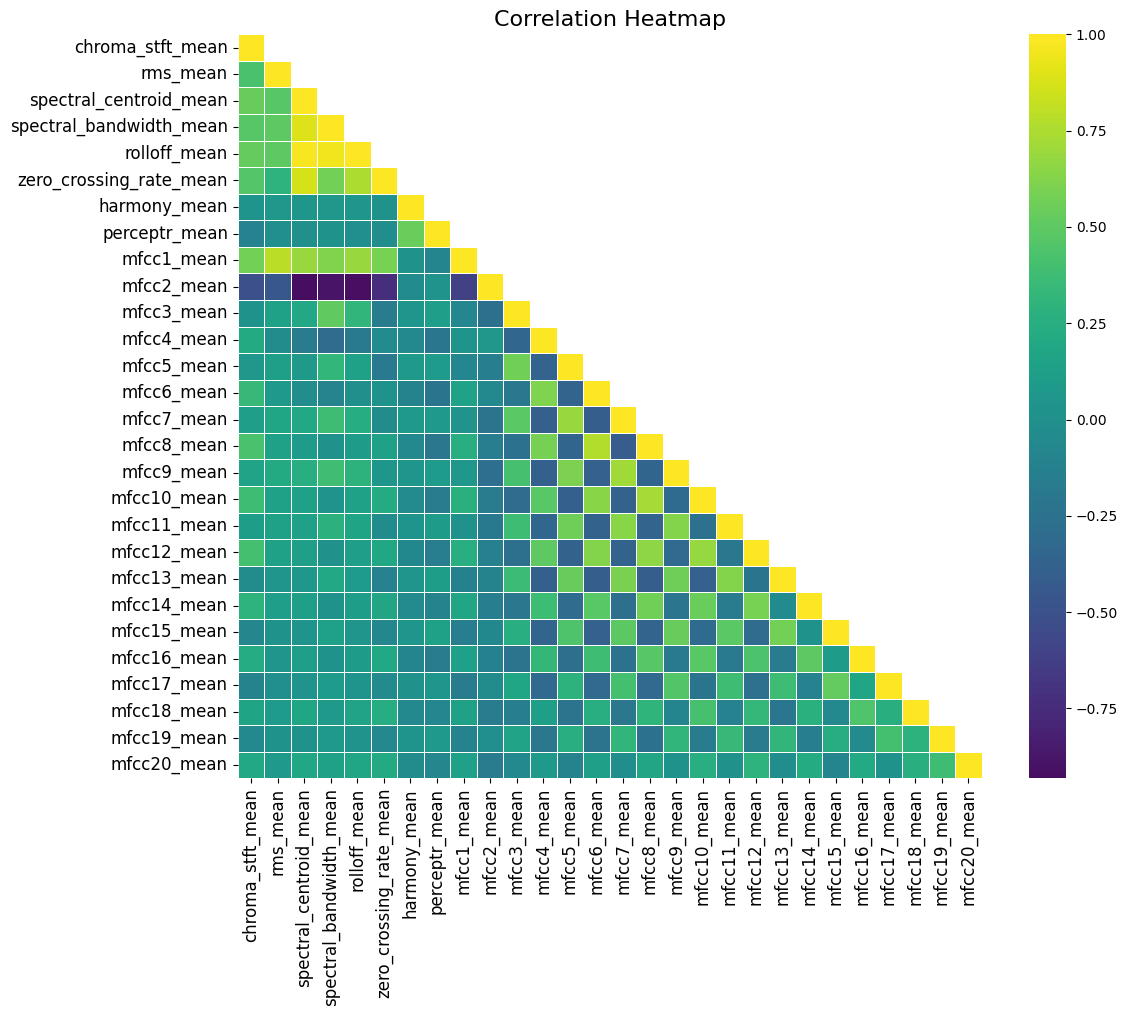

In [48]:
temp = [col for col in data.columns if 'mean' in col]
corr = data[temp].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1) 
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap='viridis', center=0, square=True, linewidths=.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'BPM')

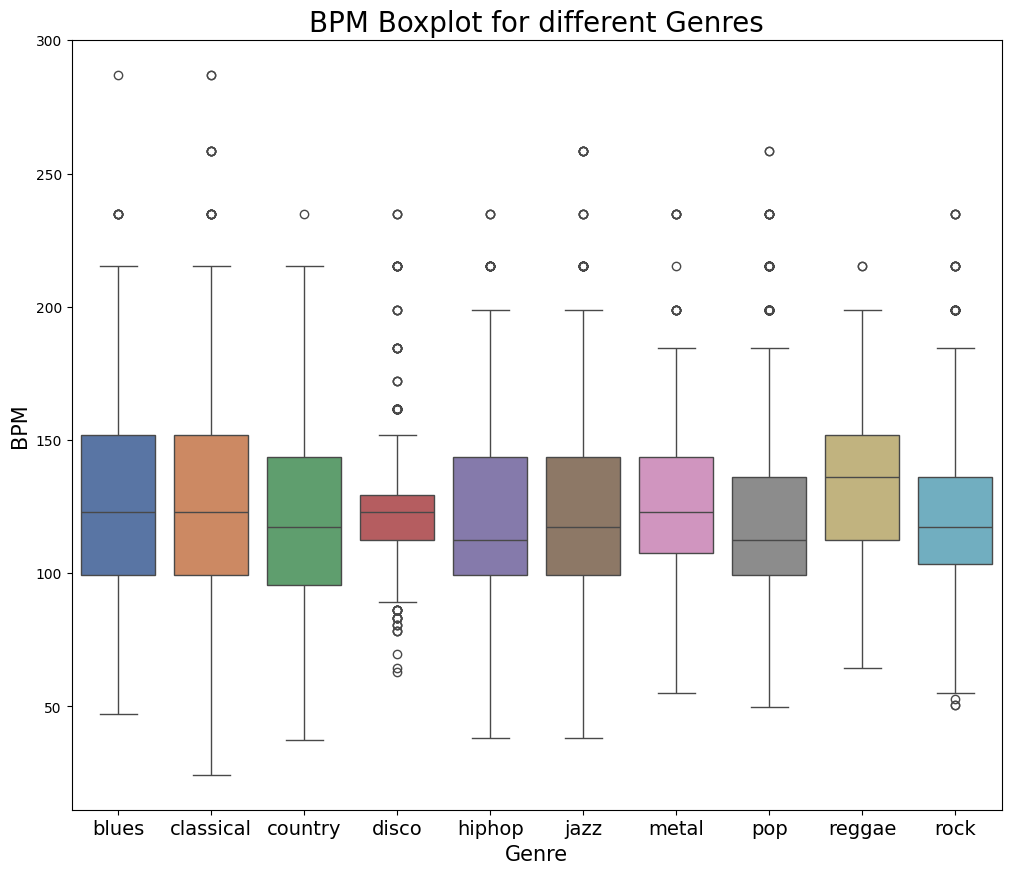

In [43]:
x = data[["label", "tempo"]]
f, ax = plt.subplots(figsize=(12,10));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'deep');
plt.title('BPM Boxplot for different Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)